In [1]:
from os import getcwd
import json 
import pinocchio as pin
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [2]:
wd = getcwd()

file1_path = wd + '/results/scene4.json'

with open(file1_path, 'r') as file:
    data = json.load(file)

In [3]:
q_dist = [x[:7] for x in data['xs_dist']]
v_dist = [x[7:] for x in data['xs_dist']]

q_vel = [x[:7] for x in data['xs_vel']]
v_vel = [x[7:] for x in data['xs_vel']]

q_nocol = [x[:7] for x in data['xs_nocol']]
v_nocol = [x[7:] for x in data['xs_nocol']]

In [4]:
import pinocchio as pin
import numpy as np
import hppfcl
from numpy import r_
from wrapper_panda import PandaWrapper
from viewer import create_viewer, add_sphere_to_viewer, add_cube_to_viewer
np.set_printoptions(precision=4, linewidth=350, suppress=True,threshold=1e6)

import yaml
from create_ocp import create_ocp_velocity, create_ocp_distance, create_ocp_nocol

# Load variables from the YAML file
with open("config_scenes.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access the 'scene' data
scene = config["scene4"]

#### Creating the robot
robot_wrapper = PandaWrapper()
rmodel, gmodel, vmodel = robot_wrapper()

radii1 = scene["DIM_OBS"][0]
radii2 = scene["DIM_ROB"][0]


gmodel.removeGeometryObject("panda1_box_0")
vmodel.removeGeometryObject("panda1_box_0")


Mobs = pin.SE3(pin.utils.rotate("y", np.pi ) @ pin.utils.rotate("z", np.pi / 2),np.array([0, 0.1, 1.2]))
rmodel.addFrame(pin.Frame("obstacle", 0, 0, Mobs, pin.OP_FRAME))

idf1 = rmodel.getFrameId("obstacle")
idj1 = rmodel.frames[idf1].parentJoint
elips1 = hppfcl.Ellipsoid(*radii1)
elips1_geom = pin.GeometryObject(
    "el1", idj1, idf1, rmodel.frames[idf1].placement, elips1
)
elips1_geom.meshColor = r_[1, 0, 0, 1]
idg1 = gmodel.addGeometryObject(elips1_geom)

idf2 = rmodel.getFrameId("panda2_hand_tcp")
idj2 = rmodel.frames[idf2].parentJoint
elips2 = hppfcl.Ellipsoid(*radii2)
elips2_geom = pin.GeometryObject(
    "el2", idj2, idf2, rmodel.frames[idf2].placement, elips2
)

elips2_geom.meshColor = r_[1, 1, 0, 1]
idg2 = gmodel.addGeometryObject(elips2_geom)
rdata,gdata = rmodel.createData(),gmodel.createData()

In [5]:
def distance_to_obs(q):
    
    pin.forwardKinematics(rmodel, rdata, np.array(q))
    pin.updateFramePlacements(rmodel, rdata)
    pin.updateGeometryPlacements(rmodel, rdata, gmodel, gdata)
    obs_placement = gdata.oMg[idg1]
    rob_placement = gdata.oMg[idg2]
    
    req = hppfcl.DistanceRequest()
    res = hppfcl.DistanceResult()
    
    distance = hppfcl.distance(elips1, obs_placement,elips2, rob_placement, req, res)
    
    return distance


def normal_to_obs(q):
        
    pin.forwardKinematics(rmodel, rdata, np.array(q))
    pin.updateFramePlacements(rmodel, rdata)
    pin.updateGeometryPlacements(rmodel, rdata, gmodel, gdata)
    obs_placement = gdata.oMg[idg1]
    rob_placement = gdata.oMg[idg2]
    
    req = hppfcl.DistanceRequest()
    res = hppfcl.DistanceResult()
    
    distance = hppfcl.distance(elips1, obs_placement,elips2, rob_placement, req, res)
    
    normal = res.getNearestPoint1() - res.getNearestPoint2()
    return normal / distance

def get_normal_speed_of_endeff(q,v):
    
    pin.forwardKinematics(rmodel, rdata, np.array(q), np.array(v))
    
    v = pin.getFrameVelocity(rmodel, rdata, idf2, pin.LOCAL_WORLD_ALIGNED).linear
    normal = normal_to_obs(q)
    return np.dot(normal,v)
    

In [6]:
dist_dist = []
dist_vel = []
dist_nocol = []

normal_vel_dist = []
normal_vel_vel = []
normal_vel_nocol = []

for q,v in zip(q_dist, v_dist):
    dist_dist.append(distance_to_obs(q))
    normal_vel_dist.append(get_normal_speed_of_endeff(q,v))
for q,v in zip(q_vel, v_vel):
    dist_vel.append(distance_to_obs(q))
    normal_vel_vel.append(get_normal_speed_of_endeff(q,v))
for q,v in zip(q_nocol, v_nocol):
    dist_nocol.append(distance_to_obs(q))
    normal_vel_nocol.append(get_normal_speed_of_endeff(q,v))

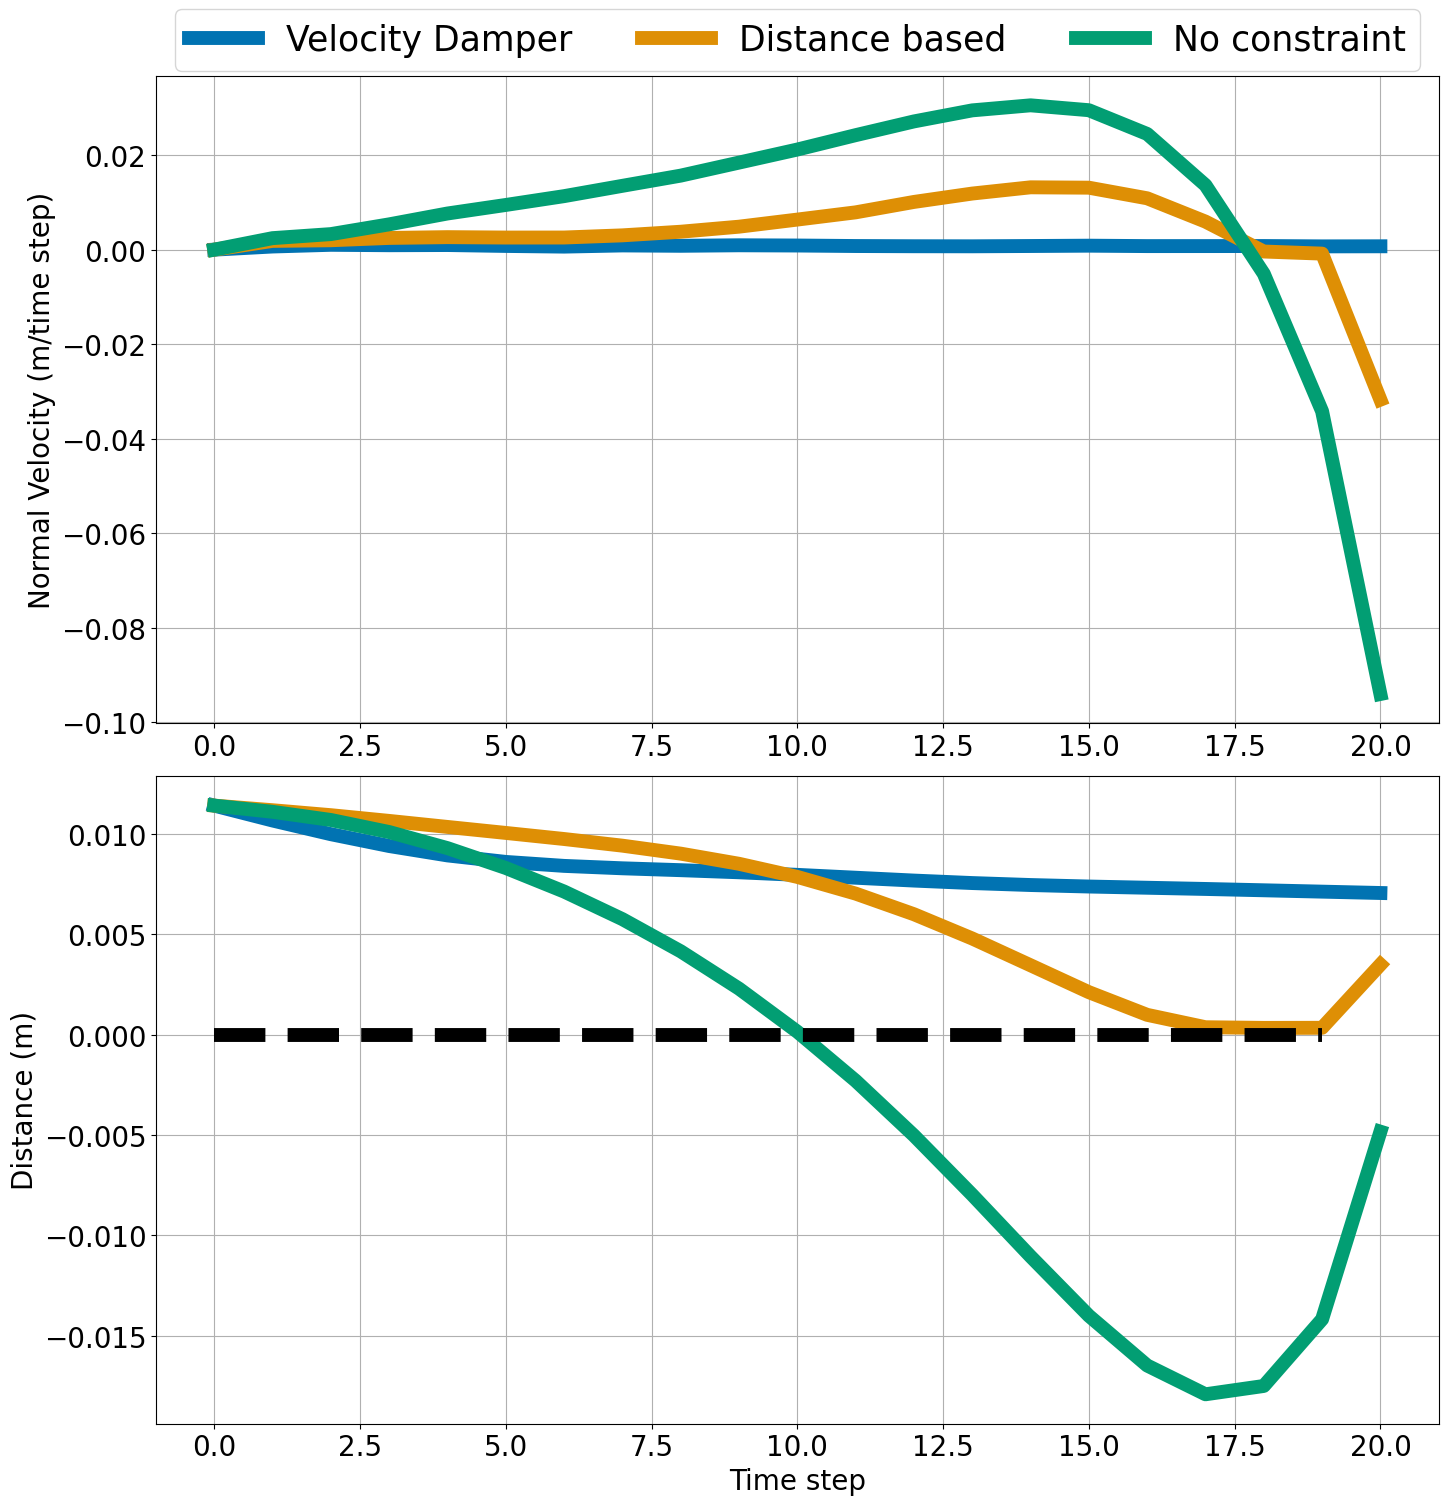

In [7]:
import seaborn as sns
import matplotlib

sns.set_palette("colorblind")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Plot the distance obstacles
fig = plt.figure(figsize=(15, 15))


plt.subplot(2, 1, 1)

plt.plot(normal_vel_vel, '-' ,  linewidth=10, label='Velocity Damper')
plt.plot(normal_vel_dist, '-' ,  linewidth=10, label='Distance based')
plt.plot(normal_vel_nocol, '-' ,  linewidth=10, label='No constraint')
plt.legend(bbox_to_anchor=(0.5, 1.13), loc='upper center', ncol=3,fontsize=25)
plt.grid()
plt.ylabel('Normal Velocity (m/time step)', fontsize=20)

plt.subplot(2, 1, 2)



plt.plot(dist_vel, '-' ,  linewidth=10, label='Velocity Damper')
plt.plot(dist_dist, '-' ,  linewidth=10, label='Distance based')
plt.plot(dist_nocol, '-' ,  linewidth=10, label='No constraint')
plt.plot(np.zeros(scene["T"]), 'k--',  linewidth=10, label='Collision')
plt.grid()
plt.ylabel('Distance (m)', fontsize=20)

# Add labels and title
plt.xlabel('Time step', fontsize=20)
plt.ylabel('Distance (m)', fontsize=20)


plt.tight_layout()
plt.show()
